In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

In [2]:
#import dataset
df = pd.read_csv('vcb.csv')
df = df[['Price','High']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Price,High
0,41700.0,42003.0
1,41624.0,42230.0
2,42003.0,42003.0
3,40942.0,41776.0
4,42003.0,42079.0
...,...,...
1483,84200.0,85300.0
1484,84200.0,84700.0
1485,83700.0,84500.0
1486,84400.0,84500.0


In [3]:
#RATIO 7:3

In [4]:
# split data ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:train_size73+test_size73]

In [5]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data73['Price'], nlags= 700)

In [6]:
# training 7:3
y_train73 = np.array(train_data73['Price'])

x_train73 = []
for data in train_data73['High']:
  x_train73.append([data])

model73 = dlm(y_train73)
model73 = model73 + trend(1, discount=0.99, name='Trend', w=1e7)
model73 = model73 + dynamic(features=x_train73, discount=1, name='High')
model73 = model73 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model73 = model73 + longSeason(period=12, stay=30, data=y_train73, name='season', w=1e7)

model73.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [7]:
# testing 7:3
x_test73 = []
for data in test_data73['High']:
  x_test73.append([data])

y_test73 = np.array(test_data73['Price'])

y_pred73 = model73.predictN(date = model73.n-1, N=len(x_test73),featureDict={'High': x_test73})
y_pred73 = y_pred73[0]


In [8]:
#  Sử dụng linear regression dự báo cột high 30 ngày tiếp theo 7:3
from sklearn.linear_model import LinearRegression

ln_model73 = LinearRegression()

ln_model73.fit(np.array(train_data73.index).reshape(-1,1), train_data73['High'])


# Predict the prices for the next 30 days
last_index73 =  df.index[-1]
last_data73 = pd.RangeIndex(start=last_index73, stop=last_index73+30, step=1)

index_next_30_days73 = np.array(range(last_index73+1, last_index73+31)).reshape(-1, 1)
high_next_30_days73 = ln_model73.predict(index_next_30_days73)

print(high_next_30_days73)


[102231.94185437 102272.78548798 102313.6291216  102354.47275521
 102395.31638883 102436.16002244 102477.00365606 102517.84728967
 102558.69092329 102599.5345569  102640.37819052 102681.22182413
 102722.06545775 102762.90909137 102803.75272498 102844.5963586
 102885.43999221 102926.28362583 102967.12725944 103007.97089306
 103048.81452667 103089.65816029 103130.5017939  103171.34542752
 103212.18906113 103253.03269475 103293.87632836 103334.71996198
 103375.56359559 103416.40722921]


In [9]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo 7:3
x_next_30_days73 = []
for data in high_next_30_days73:
  x_next_30_days73.append([data])

y_next_30_days73 = model73.predictN(N = 30, featureDict={'High': x_next_30_days73})
y_next_30_days73 = y_next_30_days73[0]
print(y_next_30_days73)


[95986.89307426219, 93201.11822336195, 94291.10023731066, 92330.79021815506, 93124.59224343607, 92886.33582490105, 93239.94836924561, 93131.98506072864, 93244.75414738037, 92899.92618980663, 93041.78514120501, 93059.15607480746, 93159.71017509955, 93183.13572283187, 93237.43086710514, 93275.04399245582, 93325.61298480426, 93369.75036065522, 93417.26930902652, 93462.49326368819, 93508.97779289847, 93554.78673948615, 93601.01771744245, 93647.00700052278, 93693.12911081339, 93739.17189004831, 93785.26071471155, 93831.32372820805, 93877.4018213681, 93923.47114676381]


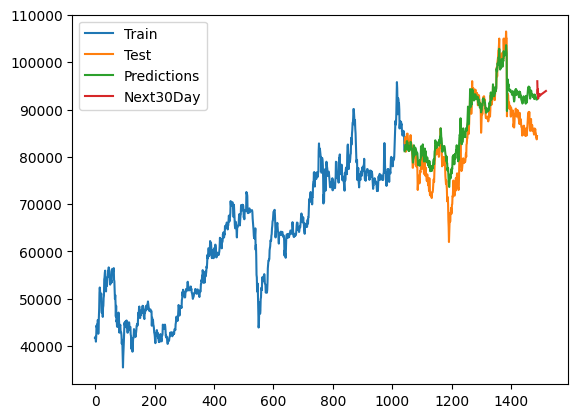

In [10]:
# 10. Vẽ hình 7:3
plt.plot(train_data73.index, train_data73['Price'])
plt.plot(test_data73.index, test_data73['Price'])
plt.plot(test_data73.index, y_pred73)
plt.plot(last_data73,y_next_30_days73)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [11]:
y_next_30_days73

[95986.89307426219,
 93201.11822336195,
 94291.10023731066,
 92330.79021815506,
 93124.59224343607,
 92886.33582490105,
 93239.94836924561,
 93131.98506072864,
 93244.75414738037,
 92899.92618980663,
 93041.78514120501,
 93059.15607480746,
 93159.71017509955,
 93183.13572283187,
 93237.43086710514,
 93275.04399245582,
 93325.61298480426,
 93369.75036065522,
 93417.26930902652,
 93462.49326368819,
 93508.97779289847,
 93554.78673948615,
 93601.01771744245,
 93647.00700052278,
 93693.12911081339,
 93739.17189004831,
 93785.26071471155,
 93831.32372820805,
 93877.4018213681,
 93923.47114676381]

In [12]:
#RATIO 8:2

In [13]:
# Split the data into training, testing, and validating sets
train_size82 = int(0.8 * len(df))
test_size82 = int(0.2 * len(df))

train_data82 = df[:train_size82]
test_data82 = df[train_size82:train_size82+test_size82]

In [14]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data82['Price'], nlags= 700)

In [15]:
# training
y_train82 = np.array(train_data82['Price'])

x_train82 = []
for data in train_data82['High']:
  x_train82.append([data])

model82 = dlm(y_train82)
model82 = model82 + trend(1, discount=0.99, name='Trend', w=1e7)
model82 = model82 + dynamic(features=x_train82, discount=1, name='High')
model82 = model82 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model82 = model82 + longSeason(period=12, stay=30, data=y_train82, name='season', w=1e7)

model82.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [16]:
# testing
x_test82= []
for data in test_data82['High']:
  x_test82.append([data])

y_test82 = np.array(test_data82['Price'])

y_pred82 = model82.predictN(date = model82.n-1, N=len(x_test82),featureDict={'High': x_test82})
y_pred82 = y_pred82[0]


In [17]:
# Sử dụng linear regression dự báo cột high 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model82 = LinearRegression()

ln_model82.fit(np.array(train_data82.index).reshape(-1,1), train_data82['High'])


# Predict the prices for the next 30 days
last_index82 =  df.index[-1]
last_data82 = pd.RangeIndex(start=last_index82, stop=last_index82+30, step=1)

index_next_30_days82 = np.array(range(last_index82+1, last_index82+31)).reshape(-1, 1)
high_next_30_days82 = ln_model82.predict(index_next_30_days82)

print(high_next_30_days82)


[97337.70731456 97374.14974397 97410.59217338 97447.03460279
 97483.47703219 97519.9194616  97556.36189101 97592.80432042
 97629.24674983 97665.68917923 97702.13160864 97738.57403805
 97775.01646746 97811.45889686 97847.90132627 97884.34375568
 97920.78618509 97957.2286145  97993.6710439  98030.11347331
 98066.55590272 98102.99833213 98139.44076154 98175.88319094
 98212.32562035 98248.76804976 98285.21047917 98321.65290857
 98358.09533798 98394.53776739]


In [18]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days82 = []
for data in high_next_30_days82:
  x_next_30_days82.append([data])

y_next_30_days82 = model82.predictN(N = 30, featureDict={'High': x_next_30_days82})
y_next_30_days82 = y_next_30_days82[0]
print(y_next_30_days82)


[64233.14251297139, 63380.81930595656, 62840.14041240769, 62514.60882589614, 62276.90940513671, 62125.493799245916, 62039.348682599804, 61992.12561150103, 61973.89277190289, 61976.95876567195, 62026.374573350506, 62064.47152622459, 62104.18325706181, 62150.94074503283, 62198.38972597788, 62246.637122784945, 62296.24979882914, 62346.45647179501, 62397.04392045917, 62447.99199712073, 62499.1671991407, 62550.492019658865, 62601.931577445874, 62653.450494145975, 62705.0236840617, 62756.63591550893, 62808.275619956075, 62859.93445764489, 62911.606822145935, 62963.28871699107]


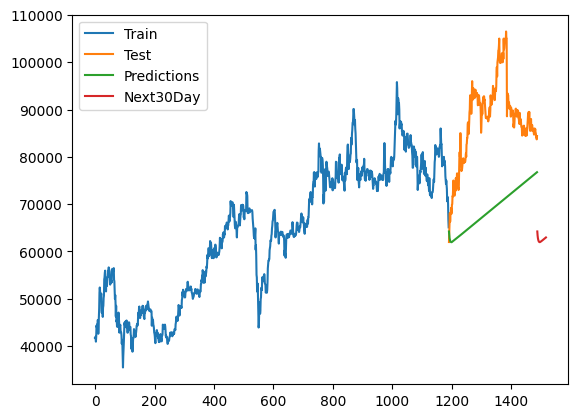

In [19]:
# 10. Vẽ hình
plt.plot(train_data82.index, train_data82['Price'])
plt.plot(test_data82.index, test_data82['Price'])
plt.plot(test_data82.index, y_pred82)
plt.plot(last_data82,y_next_30_days82)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [20]:
#RATIO 9:1

In [21]:
# Split the data into training, testing, and validating sets
train_size91 = int(0.9 * len(df))
test_size91 = int(0.1 * len(df))

train_data91 = df[:train_size91]
test_data91 = df[train_size91:train_size91+test_size91]

In [22]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data91['Price'], nlags= 700)

In [23]:
# 4. Quá trình training
y_train91 = np.array(train_data91['Price'])

x_train91 = []
for data in train_data91['High']:
  x_train91.append([data])

model91 = dlm(y_train91)
model91 = model91 + trend(1, discount=0.99, name='Trend', w=1e7)
model91 = model91 + dynamic(features=x_train91, discount=1, name='High')
model91 = model91 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model91 = model91 + longSeason(period=12, stay=30, data=y_train91, name='season', w=1e7)

model91.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [24]:
# 5. Quá trình testing
x_test91= []
for data in test_data91['High']:
  x_test91.append([data])

y_test91 = np.array(test_data91['Price'])

y_pred91 = model91.predictN(date = model91.n-1, N=len(x_test91),featureDict={'High': x_test91})
y_pred91 = y_pred91[0]


In [25]:
#  8. Sử dụng linear regression dự báo cột high 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model91 = LinearRegression()

ln_model91.fit(np.array(train_data91.index).reshape(-1,1), train_data91['High'])


# Predict the prices for the next 30 days
last_index91 =  df.index[-1]
last_data91 = pd.RangeIndex(start=last_index91, stop=last_index91+30, step=1)

index_next_30_days91 = np.array(range(last_index91+1, last_index91+31)).reshape(-1, 1)
high_next_30_days91 = ln_model91.predict(index_next_30_days91)

print(high_next_30_days91)


[95729.00721125 95763.98805608 95798.96890091 95833.94974574
 95868.93059057 95903.9114354  95938.89228024 95973.87312507
 96008.8539699  96043.83481473 96078.81565956 96113.79650439
 96148.77734922 96183.75819405 96218.73903888 96253.71988371
 96288.70072854 96323.68157337 96358.6624182  96393.64326303
 96428.62410786 96463.60495269 96498.58579753 96533.56664236
 96568.54748719 96603.52833202 96638.50917685 96673.49002168
 96708.47086651 96743.45171134]


In [26]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days91 = []
for data in high_next_30_days91:
  x_next_30_days91.append([data])

y_next_30_days91 = model91.predictN(N = 30, featureDict={'High': x_next_30_days91})
y_next_30_days91 = y_next_30_days91[0]
print(y_next_30_days91)


[95270.65461616137, 95571.11241703466, 95652.40091238901, 95744.4723391545, 95815.23823697363, 95888.3038259971, 95959.29969328824, 96030.6441690221, 96101.78091865058, 96172.96340786594, 96244.12432573814, 96176.4144669612, 96234.57258079904, 96290.65662500703, 96361.15009941722, 96430.93756362179, 96502.12773093393, 96573.16717836924, 96644.34289795702, 96715.49573515414, 96786.66224560034, 96857.82575119202, 96928.9906762918, 97000.15523358388, 97071.31994225484, 97142.48460754145, 97213.64928927731, 97284.81396599991, 97355.97864453212, 97427.1433224918]


In [27]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days91 = []
for data in high_next_30_days91:
  x_next_30_days91.append([data])

y_next_30_days91 = model91.predictN(N = 30, featureDict={'High': x_next_30_days91})
y_next_30_days91 = y_next_30_days91[0]
print(y_next_30_days91)


[95270.65461616137, 95571.11241703466, 95652.40091238901, 95744.4723391545, 95815.23823697363, 95888.3038259971, 95959.29969328824, 96030.6441690221, 96101.78091865058, 96172.96340786594, 96244.12432573814, 96176.4144669612, 96234.57258079904, 96290.65662500703, 96361.15009941722, 96430.93756362179, 96502.12773093393, 96573.16717836924, 96644.34289795702, 96715.49573515414, 96786.66224560034, 96857.82575119202, 96928.9906762918, 97000.15523358388, 97071.31994225484, 97142.48460754145, 97213.64928927731, 97284.81396599991, 97355.97864453212, 97427.1433224918]


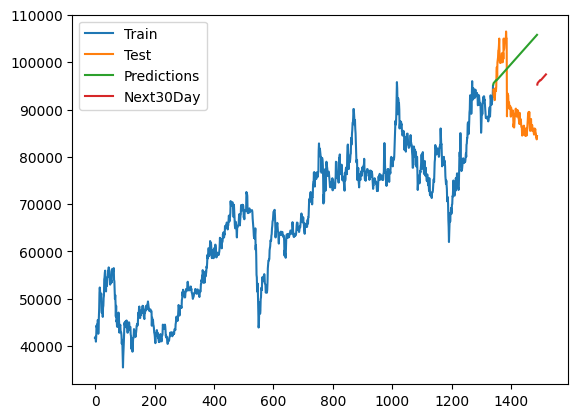

In [28]:
# 10. Vẽ hình
plt.plot(train_data91.index, train_data91['Price'])
plt.plot(test_data91.index, test_data91['Price'])
plt.plot(test_data91.index, y_pred91)
plt.plot(last_data91,y_next_30_days91)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [29]:
#ACCURACY EVALUATION

In [30]:
#method to calculate mape
def calc_mape(actual, predicted):

    # Convert to numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate absolute percentage error
    absolute_error = np.abs((actual - predicted) / actual)

    # Handle division by zero cases
    absolute_error[np.isinf(absolute_error)] = 0.0

    # Calculate mean absolute percentage error
    mape = np.mean(absolute_error) * 100

    return mape

In [31]:
#accuracy evaluate 7:3
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse73 = np.sqrt(np.mean((y_pred73 - y_test73)**2))
test_mape73 = calc_mape(y_test73, y_pred73)
test_mae73 = mae(y_test73, y_pred73)
test_msle73 = msle(y_test73, y_pred73)

print(test_rmse73)
print(test_mape73)
print(test_mae73)
print(test_msle73)

4222.008749160993
4.21781676175099
3396.9386858461735
0.0026778616069964723


In [32]:
#accuracy evaluate 8:2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse82 = np.sqrt(np.mean((y_pred82 - y_test82)**2))
test_mape82 = calc_mape(y_test82, y_pred82)
test_mae82 = mae(y_test82, y_pred82)
test_msle82 = msle(y_test82, y_pred82)

print(test_rmse82)
print(test_mape82)
print(test_mae82)
print(test_msle82)

20212.982663999075
20.81539253368011
18743.44973754478
0.06402852856646064


In [33]:
#accuracy evaluate 9:1
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle

test_rmse91 = np.sqrt(np.mean((y_pred91 - y_test91)**2))
test_mape91 = calc_mape(y_test91, y_pred91)
test_mae91 = mae(y_test91, y_pred91)
test_msle91 = msle(y_test91, y_pred91)

print(test_rmse91)
print(test_mape91)
print(test_mae91)
print(test_msle91)


12837.209255680347
12.817031828746178
11322.860707661244
0.018336587821067514
